In [ ]:
# todos:
# will turn each cell into formulas in a class
# each formula should be an option for user to choose
# create exe of console application
#   if enough time and not lazy create a simple web interface running from local dir
#       but most likely will be lazy :)

In [74]:
import pyspark, json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, concat_ws, lit, substring, initcap, lower, regexp_replace, to_timestamp
from pyspark.sql.types import StringType

In [3]:
spark = SparkSession.builder.appName('capstonedemo').getOrCreate()
branchdf = spark.read.json("cdw_sapp_branch.json")
creditdf = spark.read.json("cdw_sapp_credit.json")
customerdf = spark.read.json("cdw_sapp_customer.json")

customerdf.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States| WDunham@exam

In [4]:
# Apply mapping logic to CDW_SAPP_CUSTOMER.JSON

customerdf = customerdf.withColumn("SSN", col("SSN").cast("int"))

customerdf = customerdf.withColumn("FIRST_NAME", initcap(col("FIRST_NAME")))

customerdf = customerdf.withColumn("MIDDLE_NAME", lower(col("MIDDLE_NAME")))

customerdf = customerdf.withColumn("LAST_NAME", initcap(col("LAST_NAME")))

customerdf = customerdf.withColumnRenamed("CREDIT_CARD_NO", "Credit_card_no")

# Concatenate STREET_NAME and APT_NO with comma separator
customerdf = customerdf.withColumn("FULL_STREET_ADDRESS", concat_ws(", ", col("STREET_NAME"), col("APT_NO")))

# Format the phone number
customerdf = customerdf.withColumn("CUST_PHONE", regexp_replace(col("CUST_PHONE"), 
                                                                r"(\d{3})(\d{4})", 
                                                                concat(lit("(555)"), lit(" "), substring(col("CUST_PHONE"), 0, 3), lit("-"), substring(col("CUST_PHONE"), 4, 7))))

# Convert LAST_UPDATED to TIMESTAMP
customerdf = customerdf.withColumn("LAST_UPDATED", to_timestamp(col("LAST_UPDATED"), "yyyy-MM-dd'T'HH:mm:ss.SSSXXX"))

# Reorder columns to match json file
customerdf = customerdf.select(customerdf.FIRST_NAME, customerdf.MIDDLE_NAME, customerdf.LAST_NAME, customerdf.SSN, customerdf.Credit_card_no, 
                                customerdf.FULL_STREET_ADDRESS, customerdf.CUST_CITY, customerdf.CUST_STATE, customerdf.CUST_COUNTRY,
                                customerdf.CUST_ZIP, customerdf.CUST_PHONE, customerdf.CUST_EMAIL, customerdf.LAST_UPDATED)

customerdf.show()

# Save the transformed customer data to the target table
customerdf.write.format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "credit_card_system") \
    .mode("overwrite") \
    .option("user", "root") \
    .option("password", "password") \
    .save()

+----------+-----------+---------+---------+----------------+--------------------+------------+----------+-------------+--------+--------------+--------------------+-------------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|      SSN|  Credit_card_no| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|    CUST_PHONE|          CUST_EMAIL|       LAST_UPDATED|
+----------+-----------+---------+---------+----------------+--------------------+------------+----------+-------------+--------+--------------+--------------------+-------------------+
|      Alec|         wm|   Hooper|123456100|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(555) 123-7818| AHooper@example.com|2018-04-21 12:49:02|
|      Etta|    brendan|   Holman|123453023|4210653310102868|  Redwood Drive, 829|Wethersfield|        CT|United States|   06109|(555) 123-8933| EHolman@example.com|2018-04-21 12:49:02|
|    Wilber|   ezequiel|   Dunham|123454487|4210653310116272|12th Stre

In [5]:
creditdf.createOrReplaceTempView("transactions")
customerdf.createOrReplaceTempView("customers")

input_zip_code = input("Enter zip code: ")  #23223
input_month = int(input("Enter month: "))   #2
input_year = int(input("Enter year: "))     #2018

# Query to filter transactions by zip code, month, and year, ordered by day in descending order
query = """
SELECT t.* 
FROM transactions t
JOIN customers c ON t.CREDIT_CARD_NO = c.CREDIT_CARD_NO
WHERE c.CUST_ZIP = '{}' AND t.MONTH = {} AND t.YEAR = {}
ORDER BY t.DAY DESC
""".format(input_zip_code, input_month, input_year)

result = spark.sql(query).select(creditdf.TRANSACTION_ID, creditdf.DAY, creditdf.MONTH, creditdf.YEAR, creditdf.CREDIT_CARD_NO, 
                                 creditdf.CUST_SSN, creditdf.BRANCH_CODE, creditdf.TRANSACTION_TYPE, creditdf.TRANSACTION_VALUE)

result.show()

+--------------+---+-----+----+----------------+---------+-----------+----------------+-----------------+
|TRANSACTION_ID|DAY|MONTH|YEAR|  CREDIT_CARD_NO| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------------+---+-----+----+----------------+---------+-----------+----------------+-----------------+
|         17247| 25|    2|2018|4210653319388256|123456747|          7|           Bills|            49.97|
|         28251| 23|    2|2018|4210653369179447|123454532|         47|         Grocery|            24.41|
|         12717| 23|    2|2018|4210653335163700|123457514|         17|      Healthcare|            99.85|
|         17202| 23|    2|2018|4210653319388256|123456747|        192|       Education|            75.57|
|         17222| 22|    2|2018|4210653319388256|123456747|        100|       Education|            92.77|
|         17261| 22|    2|2018|4210653319388256|123456747|         36|             Gas|            91.07|
|         19302| 22|    2|2018|421065333745427

In [6]:
transaction_type = input("Enter transaction type: ").title()    #grocery

# Query to count how many transaction and calculate total value of transactions by type
query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS TRANSACTION_COUNT, SUM(TRANSACTION_VALUE) AS TOTAL_VALUE
FROM transactions
WHERE TRANSACTION_TYPE = '{}'
GROUP BY TRANSACTION_TYPE
""".format(transaction_type)

result = spark.sql(query)

result.show()

+----------------+-----------------+-----------------+
|TRANSACTION_TYPE|TRANSACTION_COUNT|      TOTAL_VALUE|
+----------------+-----------------+-----------------+
|         Grocery|             6549|337051.6299999992|
+----------------+-----------------+-----------------+



In [7]:
branchdf.createOrReplaceTempView("branches")

state = input("Enter state abbreviation: ").upper() #ny

# Query to count the number and calculate the total value of transactions by branch and state
query = """
SELECT b.BRANCH_CODE, b.BRANCH_NAME, SUM(t.TRANSACTION_VALUE) AS total_value, COUNT(*) AS total_transactions
FROM branches b
JOIN transactions t ON b.BRANCH_CODE = t.BRANCH_CODE
WHERE b.BRANCH_STATE = '{}'
GROUP BY b.BRANCH_CODE, b.BRANCH_NAME
""".format(state)

result = spark.sql(query)

result.show()

+-----------+------------+------------------+------------------+
|BRANCH_CODE| BRANCH_NAME|       total_value|total_transactions|
+-----------+------------+------------------+------------------+
|         66|Example Bank|21723.449999999997|               412|
|        160|Example Bank|20257.590000000004|               400|
|          8|Example Bank|          21809.74|               431|
|         93|Example Bank|21698.670000000013|               416|
|        178|Example Bank|18968.330000000005|               398|
|        175|Example Bank|20524.619999999995|               393|
|         16|Example Bank|22766.419999999987|               434|
|        135|Example Bank|20710.990000000005|               383|
|         46|Example Bank| 23507.65999999999|               445|
|          3|Example Bank|          21749.91|               431|
+-----------+------------+------------------+------------------+



In [8]:
ssn = int(input("Enter SSN: ")) #123459988

# Query for customer
query = """
SELECT *
FROM customers
WHERE SSN = {}
""".format(ssn)

result = spark.sql(query)
result.show()

+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|      SSN|  Credit_card_no|FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|    CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+
|    Amalia|        hal|   Campos|123459988|4210653349028689|  Valley Drive, 774|Harleysville|        PA|United States|   19438|(555) 123-6163|ACampos@example.com|2018-04-21 12:49:02|
+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+



In [19]:
# input code to give option to modify customer details or not
# if yes

# will ask for inputs for new details but currently testing with hardcode
updated_first_name = "Jane"
updated_middle_name = "Doe"
updated_last_name = "Smith"
updated_apt_no = "123"
updated_street_name = "Main Street"
updated_cust_city = "New York"
updated_cust_state = "NY"
updated_cust_zip = 10001
updated_cust_phone = "555-1234"
updated_cust_email = "JSmith@example.com"

'''
original data

+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|      SSN|  Credit_card_no|FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|    CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+
|    Amalia|        hal|   Campos|123459988|4210653349028689|  Valley Drive, 774|Harleysville|        PA|United States|   19438|(555) 123-6163|ACampos@example.com|2018-04-21 12:49:02|
+----------+-----------+---------+---------+----------------+-------------------+------------+----------+-------------+--------+--------------+-------------------+-------------------+
'''

# Read the JSON file
with open("cdw_sapp_customer.json", "r") as file:
    customers_json = [json.loads(line) for line in file]

# Find the customer with the specified SSN and update their details
for customer in customers_json:
    if customer["SSN"] == ssn:
        # Update the fields that have changed
        if updated_first_name != "":
            customer["FIRST_NAME"] = updated_first_name
        if updated_middle_name != "":
            customer["MIDDLE_NAME"] = updated_middle_name
        if updated_last_name != "":
            customer["LAST_NAME"] = updated_last_name
        if updated_apt_no != "":
            customer["APT_NO"] = updated_apt_no
        if updated_street_name != "":
            customer["STREET_NAME"] = updated_street_name
        if updated_cust_city != "":
            customer["CUST_CITY"] = updated_cust_city
        if updated_cust_state != "":
            customer["CUST_STATE"] = updated_cust_state
        if updated_cust_zip != "":
            customer["CUST_ZIP"] = updated_cust_zip
        if updated_cust_phone != "":
            customer["CUST_PHONE"] = updated_cust_phone
        if updated_cust_email != "":
            customer["CUST_EMAIL"] = updated_cust_email
        break

# Write the updated customer data back to the JSON file
with open("cdw_sapp_customer.json", "w") as file:
    for customer in customers_json:
        json.dump(customer, file)
        file.write("\n")


# Run mapping cell again to update SQL


print("Customer details updated and saved.")


Customer details updated and saved to the JSON file.


In [9]:
credit_card_number = "4210653310061055" #based on person

input_month = int(input("Enter month: "))   #6
input_year = int(input("Enter year: "))     #2018

# Filter credit based on credit card number, month, and year
filtered_df = creditdf.filter((creditdf["CREDIT_CARD_NO"] == credit_card_number) &
                        (creditdf["MONTH"] == input_month) &
                        (creditdf["YEAR"] == input_year))\
                            .select(creditdf.YEAR, creditdf.MONTH, creditdf.DAY, 
                                    creditdf.TRANSACTION_TYPE, creditdf.TRANSACTION_VALUE)

filtered_df.show()

# Calculate the total amount spent
total_transaction_value = filtered_df.agg({"TRANSACTION_VALUE": "sum"}).collect()[0][0]

print("Payment Due: {}".format(total_transaction_value))

+----+-----+---+----------------+-----------------+
|YEAR|MONTH|DAY|TRANSACTION_TYPE|TRANSACTION_VALUE|
+----+-----+---+----------------+-----------------+
|2018|    6|  7|         Grocery|            42.57|
|2018|    6| 11|            Test|            26.96|
|2018|    6| 19|   Entertainment|            81.94|
|2018|    6|  2|            Test|            86.14|
+----+-----+---+----------------+-----------------+

Payment Due: 237.61


In [11]:
start_date = (input("Enter start date (YYYY-MM-DD): ")) #2018-04-01
end_date = (input("Enter end date (YYYY-MM-DD): "))     #2018-08-04

# Check to make sure end_date comes after start_date and follow format

# Filter credit based on SSN and date range
filtered_df = creditdf.filter((creditdf["CUST_SSN"] == ssn) &
                            (creditdf["YEAR"].between(start_date[:4], end_date[:4])) &
                            (creditdf["MONTH"].between(start_date[5:7], end_date[5:7])) &
                            (creditdf["DAY"].between(start_date[8:], end_date[8:])))

# Sort by year, month, and day in descending order
sorted_df = filtered_df.orderBy(col("YEAR").desc(), col("MONTH").desc(), col("DAY").desc())

sorted_df = sorted_df.select(creditdf.TRANSACTION_ID, creditdf.YEAR, creditdf.MONTH, creditdf.DAY,
                             creditdf.CREDIT_CARD_NO, creditdf.CUST_SSN, creditdf.BRANCH_CODE,
                             creditdf.TRANSACTION_TYPE, creditdf.TRANSACTION_VALUE)

sorted_df.show()


+--------------+----+-----+---+----------------+---------+-----------+----------------+-----------------+
|TRANSACTION_ID|YEAR|MONTH|DAY|  CREDIT_CARD_NO| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------------+----+-----+---+----------------+---------+-----------+----------------+-----------------+
|            92|2018|    8|  3|4210653349028689|123459988|         66|       Education|            58.25|
|            18|2018|    7|  4|4210653349028689|123459988|        135|   Entertainment|            88.75|
|            93|2018|    7|  2|4210653349028689|123459988|         99|             Gas|            41.06|
|            43|2018|    6|  4|4210653349028689|123459988|         79|             Gas|            83.33|
|            13|2018|    4|  3|4210653349028689|123459988|         80|         Grocery|            40.24|
+--------------+----+-----+---+----------------+---------+-----------+----------------+-----------------+



In [13]:
import matplotlib.pyplot as plt

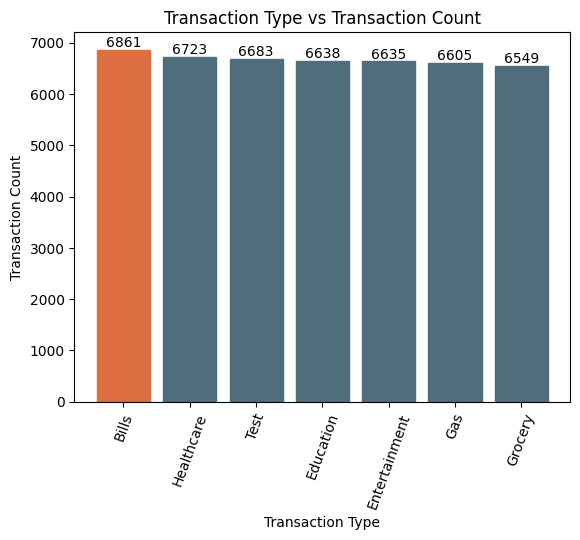

In [70]:
# Group by transaction type and count the number of transactions
transaction_count = creditdf.groupBy("TRANSACTION_TYPE").count().alias("transaction_count")

# Sort the transactions by count in descending order
sorted_transactions = transaction_count.orderBy("count", ascending=False).collect()

# Get transaction types and counts
transaction_types = [row["TRANSACTION_TYPE"] for row in sorted_transactions]
transaction_count = [row["count"] for row in sorted_transactions]

# Plot transaction types and counts
bars = plt.bar(transaction_types, transaction_count)
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Count")
plt.title("Transaction Type vs Transaction Count")
plt.xticks(rotation=70)

# Labels and colors for readability
bars[0].set_color("#dd6e42")
for bar in bars[1:]:
    bar.set_color("#4f6d7a")

for i in range(len(transaction_types)):
    plt.text(i, transaction_count[i], str(transaction_count[i]), ha="center", va="bottom")

plt.show()

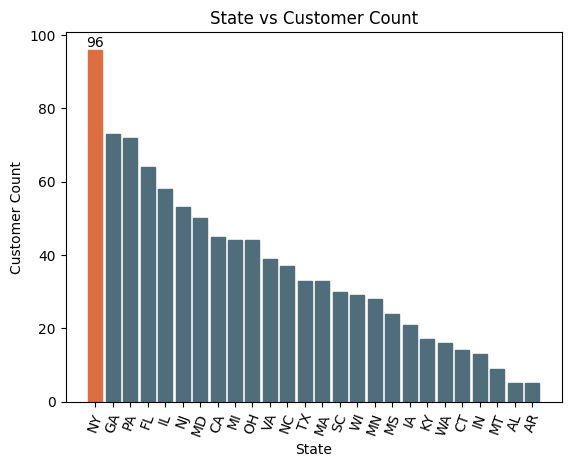

In [71]:
# Group by state and count the number of customers
customer_count = customerdf.groupBy("CUST_STATE").agg({"SSN": "count"}).alias("customer_count")

# Sort the states by count in descending order
sorted_states = customer_count.orderBy("count(SSN)", ascending=False).collect()

# Get states and customer counts
states = [row["CUST_STATE"] for row in sorted_states]
customer_count = [row["count(SSN)"] for row in sorted_states]

# Plot states and customer counts
bars = plt.bar(states, customer_count)
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("State vs Customer Count")
plt.xticks(rotation=70)

# Labels and colors for readability
bars[0].set_color("#dd6e42")
for bar in bars[1:]:
    bar.set_color("#4f6d7a")

plt.text(0, customer_count[0], str(customer_count[0]), ha="center", va="bottom")

plt.show()


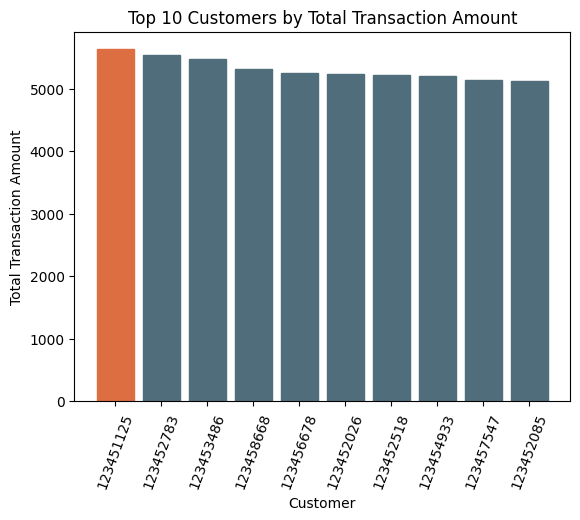

In [94]:
# Group by customer SSN and sum the transaction amounts
customer_transactions = creditdf.groupBy("CUST_SSN").agg({"TRANSACTION_VALUE": "sum"}).alias("transaction_amount")

# Sort the transactions by sum in descending order
top_10_customers = customer_transactions.orderBy("sum(TRANSACTION_VALUE)", ascending=False).limit(10).collect()

# Get top 10 customers and transaction sums
customer_ssn = [str(row["CUST_SSN"]) for row in top_10_customers]
transaction_amount = [row["sum(TRANSACTION_VALUE)"] for row in top_10_customers]

# Plot customer SSNs and transaction sums
bars = plt.bar(customer_ssn, transaction_amount)
plt.xlabel("Customer")
plt.ylabel("Total Transaction Amount")
plt.title("Top 10 Customers by Total Transaction Amount")
plt.xticks(rotation=70)

# Labels and colors for readability
bars[0].set_color("#dd6e42")
for bar in bars[1:]:
    bar.set_color("#4f6d7a")

plt.show()